# U-Net Segmentation Approach to Cancer Diagnosis
*written by Jonathan Mulholland, Data Scientist, Booz Allen Hamilton*

In this tutorial, we will show one approach to predicting whether a CT scan is of a patient who either has or will develop cancer within the next 12 months or not.

We will train a network to segment out potentially cancerous nodules and then use the characteristics of that segmentation to make predictions about the diagnosis of the scanned patient within a 12 month time frame. 

The code for this tutorial can be found at https://github.com/booz-allen-hamilton/DSB3Tutorial 
## Dependencies and tools
This tutorial uses python and has the following dependencies

* numpy
* scikit-image
* scikit-learn 
* keras (tensorflow backend)
* matplotlib
* pydicom
* SimpleITK

Note: Keras allows multiple backends for use when training. We chose a GPU enabled installation of tensorflow as the backend of Keras.

In order to identify regions with nodules, we will use a U-Net style convolutional network which was designed for segmenting neuronal structures. https://arxiv.org/abs/1505.04597 

Our code for the network was based on a turorial posted by Marko Jocic on the Kaggle forum for the Ultrasound Nerve Segmentation Challenge. https://www.kaggle.com/c/ultrasound-nerve-segmentation/forums/t/21358/0-57-deep-learning-keras-tutorial

The images we'll be predicting cancer diagnoses on are scans from low-dose helical computed tomography (CT). The appearance on nodules within the CT scan indicate the possibility of cancer, and we will need training examples with marked nodules in order train the U Net to find these nodules. Rather than hand label images, we turn to the Lung Nodule Analysis 2016 (LUNA2016) challenge which has made available CT images with annotated nodule locations. We will first use the LUNA data set to generate an appropriate training set for our U-Net. We will use these examples to train our supervised segmenter. 

## Constructing a training set from the LUNA 2016 data


We are going to use the nodule locations as given in annotations.csv and extract three transverse slices that contain the largest nodule from each patient scan. Masks will be created for those slices based on the nodule dimensions given in annotations.csv. The output of this file will be two files for each patient scan: a set of images and a set of corresponding nodule masks. The data from the LUNA 2016 challenge can be found at https://luna16.grand-challenge.org/

First we import the necessary tools and find the largest nodule in the patient scan. There are multiple nodule listings for some patients in annotations.csv. We're using a pandas DataFrame named ```df_node``` to keep track of the case numbers and the node information. The node information is an (x,y,z) coordinate in mm using a coordinate system defined in the .mhd file. 

The following snippets of code are from LUNA_mask_extraction.py:

In [17]:
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd

luna_subset_path = '/kaggle/dev/luna-2016-data/'
luna_path = '/kaggle/dev/luna-2016-data/'


file_list = glob(luna_subset_path + "subset?/*.mhd")
#####################
#
# Helper function to get rows in data frame associated 
# with each file
def get_filename(case):
    global file_list
    for f in file_list:
        if case in f:
            return(f)
#
# The locations of the nodes
df_node = pd.read_csv(luna_path + "annotations.csv")
df_node["file"] = df_node["seriesuid"].apply(get_filename)
df_node = df_node.dropna()

print(df_node)
#####
#
# Looping over the image files
#
fcount = 0
for img_file in file_list:
    print("Getting mask for image file %s" % img_file.replace(luna_subset_path,""))
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if len(mini_df)>0:       # some files may not have a nodule--skipping those 
        biggest_node = np.argsort(mini_df["diameter_mm"].values)[-1]   # just using the biggest node
        node_x = mini_df["coordX"].values[biggest_node]
        node_y = mini_df["coordY"].values[biggest_node]
        node_z = mini_df["coordZ"].values[biggest_node]
        diam = mini_df["diameter_mm"].values[biggest_node]



                                              seriesuid      coordX  \
0     1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421   
1     1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651   
2     1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017   
3     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824   
4     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547   
5     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   90.931713   
6     1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   89.540769   
7     1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...   81.509646   
8     1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...  105.055792   
9     1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760... -124.834262   
10    1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985... -106.901301   
11    1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...    2.263816   
12    1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920...  -70.550889   
13    

## Getting the nodule position in the mhd files

The nodule locations are given in terms of millimeters relative to a coordinate system defined by the CT scanner. The image data is given as a varying length stack of 512 X 512 arrays. In order to translate the voxel position to the world coordinate system, one needs to know the real world position of the [0,0,0] voxel and the voxel spacing in mm. 

To find the voxel coordinates of a nodule, given its real world position, we use the ```GetOrigin()``` and ```GetSpacing()``` method of the itk image object:

In [26]:
itk_img = sitk.ReadImage(img_file) 
img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
center = np.array([node_x,node_y,node_z])   # nodule center
origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)

width = 20
height = 20

In [27]:
def make_mask(center,diam,z,width,height,spacing,origin):
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

In [28]:
i = 0
for i_z in range(int(v_center[2])-1,int(v_center[2])+2):
    mask = make_mask(center,diam,i_z*spacing[2]+origin[2],width,height,spacing,origin)
    masks[i] = mask
    imgs[i] = matrix2int16(img_array[i_z])
    i+=1
np.save(output_path+"images_%d.npy" % (fcount) ,imgs)
np.save(output_path+"masks_%d.npy" % (fcount) ,masks)

NameError: name 'v_xrange' is not defined

In [21]:
The center of the nodule is located in the ```v_center[2]``` slice of the img_array. We pass the node information to the ```make_mask()``` function and copy the generated masks and the image for the ```v_center[2]```slice and the slice above and below it. 

Should we collect more slices from each scan?

Since the nodule locations are defined in terms of spheres, and the nodules are irregularly shaped, slices near the edges of the spheres may contain no nodule tissue. Using such slices would contaminate the training set with false positives. For this segmentation project, there is probably an optimal number of slices through a nodule that one should incorporate. For simplicity, we stick to 3 and only pull the slices centered on the largest nodule. 

image %d 0


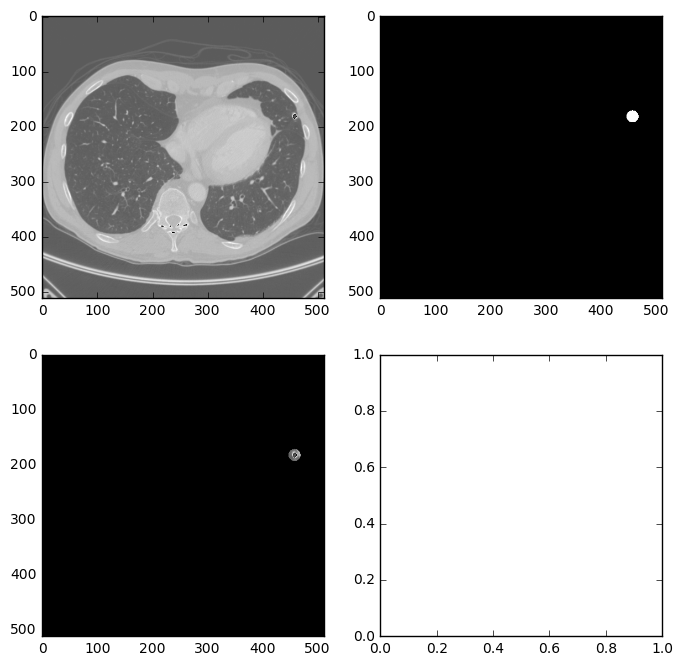

NameError: name 'raw_input' is not defined

In [31]:
output_path = "/kaggle/dev/luna-2016-data/output/"
import matplotlib.pyplot as plt

imgs = np.load(output_path+'images_0.npy')
masks = np.load(output_path+'masks_0.npy')
for i in range(len(imgs)):
    print("image %d", i)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(masks[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*masks[i],cmap='gray')
    plt.show()
    raw_input("hit enter to cont : ")

## Isolation of the Lung Region of Interest to Narrow Our Nodule Search

The node masks seem to be constructed properly. The next step is to isolate the lungs in the images. We'll need
to import some skimage image processing modules for this step. The general strategy is to threshold the image to isolate the 
regions within the image, and then to identify which of those regions are the lungs. The lungs have a high constrast with the surrounding tissue, so the thresholding is fairly straightforward. We use some ad-hoc criteria for eliminating the non-lung regions from the image which do not apply equally to all data sets. 

In addition to our previous imports, we'll make use of ...

```
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
```

These steps are found in LUNA_segment_lung_ROI.py

The arrays were loaded as ```dtype = np.float64``` because ```KMeans``` in sklearn has a bug related to the precision of the input to ```KMeans```. 

We'll walk through the steps of isolating the lung ROI with ```img```, which is a 512 X 512 slice from the set we extracted from the LUNA 2016 data, which looks like:

![ROI Step 1](https://kaggle2.blob.core.windows.net/competitions/kaggle/6004/media/ROI_step1.png)



### Thresholding

Our first step is to standardize the pixel values and take a look at the intensity distribution

```
img = imgs_to_process[i]
#Standardize the pixel values
mean = np.mean(img)
std = np.std(img)
img = img-mean
img = img/std
plt.hist(img.flatten(),bins=200)
```
![ROI Step 1 hist](https://kaggle2.blob.core.windows.net/competitions/kaggle/6004/media/ROI_step1_hist.png)

The underflow peak near -1.5 is the black out-of-scanner part of the image. The peaks around 0.0 are the background and lung interior and the wide clumps from 1.0 to 2.0 are the non-lung-tissue and bone. The structure of this histogram varies throughout the data set. Two images are shown below that are typical of the data set. The one on the left has the same black background around a grey circular region of scanner data as is present in ```img```. That black background is not present in the image on the right, making for a very different pixel value histogram.   

![ROI Hist Diff](https://kaggle2.blob.core.windows.net/competitions/kaggle/6004/media/ROI_hist_diff.png)

We have to make sure that we set our threshold between the lung pixel values and the denser tissue pixel values. To do this, we reset the pixels with the minimum value to the average pixel value near the center of the picture and perform kmeans clustering with k=2. This seems to work well for both scenarios. 

```
middle = img[100:400,100:400] 
mean = np.mean(middle)  
max = np.max(img)
min = np.min(img)
#move the underflow bins
img[img==max]=mean
img[img==min]=mean

kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)
thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
```

Which produces a satisfactory separation of regions for both types of images and eliminates the black halo in the one on the left

![ROI Step 2](https://kaggle2.blob.core.windows.net/competitions/kaggle/6004/media/ROI_step2.png)


### Erosion and Dilation

We then use an erosion and dilation to fill in the incursions into the lungs region by radio-opaque tissue, followed by a selection of the regions based on the bounding box sizes of each region. The initial set of regions looks like 
```
eroded = morphology.erosion(thresh_img,np.ones([4,4]))
dilation = morphology.dilation(eroded,np.ones([10,10]))
labels = measure.label(dilation)
label_vals = np.unique(labels)
plt.imshow(labels)
```
![ROI Step 3](https://kaggle2.blob.core.windows.net/competitions/kaggle/6004/media/ROI_step3.png)

### Cutting non-ROI Regions
The cuts applied to each region bounding box were determined empirically and seem to work well for the LUNA data, but may not be generally applicable
```
labels = measure.label(dilation)
label_vals = np.unique(labels)
regions = measure.regionprops(labels)
good_labels = []
for prop in regions:
    B = prop.bbox
    if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
        good_labels.append(prop.label)
mask = np.ndarray([512,512],dtype=np.int8)
mask[:] = 0
#
#  The mask here is the mask for the lungs--not the nodes
#  After just the lungs are left, we do another large dilation
#  in order to fill in and out the lung mask 
#
for N in good_labels:
    mask = mask + np.where(labels==N,1,0)
mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
plt.imshow(mask,cmap='gray')
```
![ROI Step 4](https://kaggle2.blob.core.windows.net/competitions/kaggle/6004/media/ROI_step4.png)


### Applying the ROI Masks

The next step in LUNA_segment_lung_ROI.py is applying the mask of the lung ROI to each of the images, cropping down to the bounding square of the lungs ROI, and then resizing the resulting image to 512 X 512. 
```
masks = np.load(working_path+"lungmask_0.py")
imgs = np.load(working_path+"images_0.py")
imgs = masks*imgs
```
...crop to bounding square and resize to 512 X 512...

Then we perform some final pixel normalization. This is because the mask sends the non ROI area in the picture to 0, and that operation is not sensitive to the pixel value distribution. To fix this, we get the mean and standard deviation of the masked region and send the background (now zero) to the lower end of the pixel distribution (```-1.2*stdev```, which was chosen empirically). 
```
#
# renormalizing the masked image (in the mask region)
#
new_mean = np.mean(img[mask>0])  
new_std = np.std(img[mask>0])
#
#  Pushing the background color up to the lower end
#  of the pixel range for the lungs
#
old_min = np.min(img)       # background color
img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
img = img-new_mean
img = img/new_std
```

The final product is a set of lungs that is ready to be compiled into our training example set. 

![ROI Step 5](https://kaggle2.blob.core.windows.net/competitions/kaggle/6004/media/ROI_step5.png)

These images and the correspondingly trimmed and rescaled masks are randomized and sent to a single file that contains a numpy array of dimension ```[<num_images>,1,512,512]```. The 1 is important as the U-net is enabled for multiple channels. 

```
#
#  Writing out images and masks as 1 channel arrays for input into network
#
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
for i in range(num_images):
    final_images[i,0] = out_images[i]
    final_masks[i,0] = out_nodemasks[i]

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
np.save(working_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(working_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(working_path+"testImages.npy",final_images[rand_i[:test_i]])
np.save(working_path+"testMasks.npy",final_masks[rand_i[:test_i]])

```



image %d 0


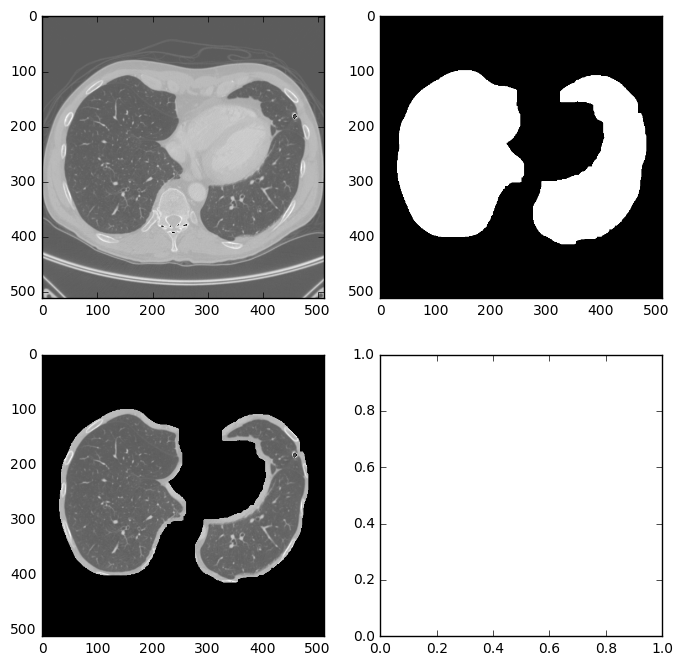

hit enter to cont : 
image %d 1


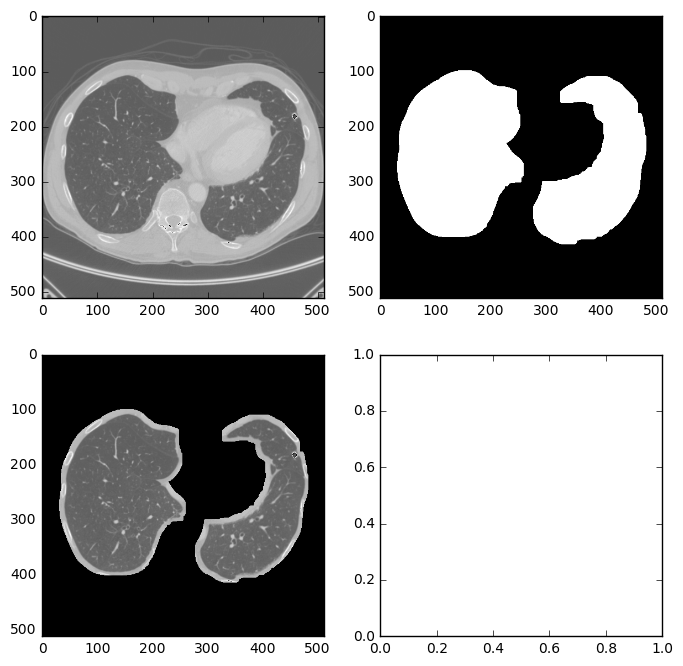

hit enter to cont : 
image %d 2


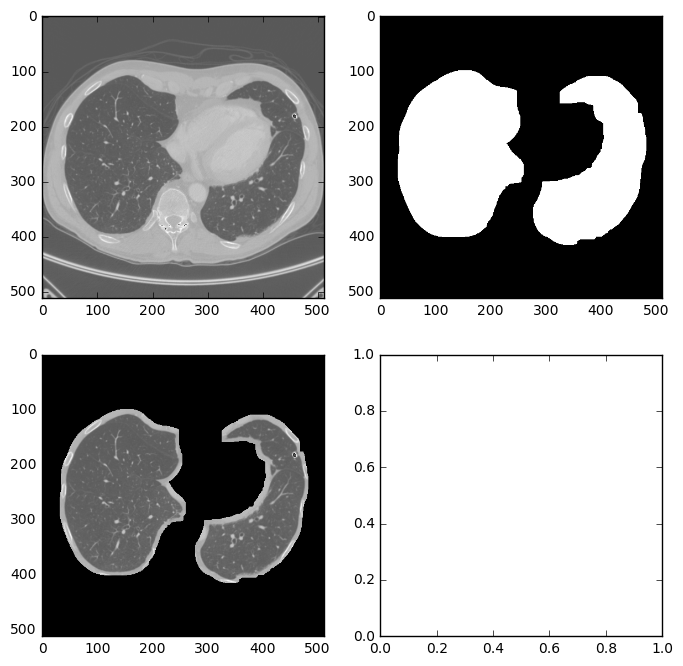

hit enter to cont : 


In [37]:
working_path = "/kaggle/dev/luna-2016-data/output/"

imgs = np.load(working_path + 'images_0.npy')
lungmask = np.load(working_path+'lungmask_0.npy')

for i in range(len(imgs)):
    print("image %d", i)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(lungmask[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*lungmask[i],cmap='gray')
    plt.show()
    input("hit enter to cont : ")

### Dice Ceofficient Cost function for Segmentation
The network we'll be using is the U-net linked to the beginning of the tutorial which 
uses the keras framework. The loss function is the dice coefficient 
https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
comparing the predicted and actual node mask. 

The following code snippets are all taken from LUNA_train_unet.py

The loss function is as follows: 

```
smooth = 1.
# Tensorflow version for the model
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
```
Which is similar to the metric used to evaluate the Ultrasound Nerve Segmentation challenge that this network was originally written for (once again, see the link at the beginning of this tutorial).

### Loading the Segmenter
The function call
```
model = get_unet() 
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)
```
will compile and return the model and tell keras to save the model weights during checkpoints. If you want to load the best weights from a previous training session or use the weights included in this tutorial's repo, load the weight file with the line
```
model.load_weights('unet.hdf5')
```

### Training the Segmenter
Calling LUNA_train_unet.py from the command line will automatically attempt to load a unet.hdf5 file from the current directory, train it according to the parameters set by the line
```
model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=20, 
           verbose=1, shuffle=True,callbacks=[model_checkpoint])
```
in the script, and make predictions on the test set.
```
num_test = len(imgs_test)
imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
for i in range(num_test):
    imgs_mask_test[i] = model.predict([imgs_test[i:i+1]], verbose=0)[0]
np.save('masksTestPredicted.npy', imgs_mask_test)
mean = 0.0
for i in range(num_test):
    mean+=dice_coef_np(imgs_mask_test_true[i,0], imgs_mask_test[i,0])
mean/=num_test
print("Mean Dice Coeff : ",mean)
```
The ```model.predict()``` function can take more than one case at a time, but that can quickly overload a GPU, so we are looping over individual cases. 

The final results for this tutorial were produced using a multi-GPU machine using TitanX's. For a home GPU computation benchmark, a personal set up with a GTX970 we were able to run 20 epochs with a training set size of 320 and batch size of 2 in about an hour. We started obtaing reasonable nodule mask predictions after about 3 hours of training once the reported loss value approached 0.3. 

An example segmentation is given here for the three slices taken from a patient scan. The perfect circle is the "true" node mask from the LUNA annotationc.csv file, and the red is the predicted node region from the segmenter. The original image is given in the top right. 

![Example Segmentation](https://kaggle2.blob.core.windows.net/competitions/kaggle/6004/media/example_segmentation.png)



## Training a Classifier for Identifying Cancer

Now we are ready to begin training a classifier using our image segmentation from the previous sections to generate features. 

The Data Science Bowl training data set must be fed through the segmenter, which can be done largely by reusing the code used to treat the LUNA data. There are two points where this deviates.

First of all, the DSB data is in dicom format, which can be read using the pydicom module
```
import dicom
dc = dicom.read_file(filename)
img = dc.pixel_array
```
Secondly, in order to locate nodes in the scans, every layer of the scan must be run through the segmenter, and thus every layer must also be subject to the image processing to mask off the ROI. This can be a very time consuming process. 






## Simple classifier based on nodule features
We start by characterizing some of the features of the nodule maps and putting them into a feature vector that we can use for classification purposes. Our list of features is by no means exhaustive and is meant to illustrate the process of developing some meterics that could be used to characterize the segmented regions where nodules are likely.

We encourage you to play with adding some new features, explore convolutional models for extracting features from the region of interest directly. We have included some features about the average size, morphology, and position within the image for use in model building. 


```
def getRegionMetricRow(fname = "nodules.npy"):
    seg = np.load(fname)
    nslices = seg.shape[0]
    
    #metrics
    totalArea = 0.
    avgArea = 0.
    maxArea = 0.
    avgEcc = 0.
    avgEquivlentDiameter = 0.
    stdEquivlentDiameter = 0.
    weightedX = 0.
    weightedY = 0.
    numNodes = 0.
    numNodesperSlice = 0.
    # do not allow any nodes to be larger than 10% of the pixels to eliminate background regions
    maxAllowedArea = 0.10 * 512 * 512 
    
    areas = []
    eqDiameters = []
    for slicen in range(nslices):
        regions = getRegionFromMap(seg[slicen,0,:,:])
        for region in regions:
            if region.area > maxAllowedArea:
                continue
            totalArea += region.area
            areas.append(region.area)
            avgEcc += region.eccentricity
            avgEquivlentDiameter += region.equivalent_diameter
            eqDiameters.append(region.equivalent_diameter)
            weightedX += region.centroid[0]*region.area
            weightedY += region.centroid[1]*region.area
            numNodes += 1
            
    weightedX = weightedX / totalArea 
    weightedY = weightedY / totalArea
    avgArea = totalArea / numNodes
    avgEcc = avgEcc / numNodes
    avgEquivlentDiameter = avgEquivlentDiameter / numNodes
    stdEquivlentDiameter = np.std(eqDiameters)
    
    maxArea = max(areas)
    
    
    numNodesperSlice = numNodes*1. / nslices
    
    
    return np.array([avgArea,maxArea,avgEcc,avgEquivlentDiameter,\
                     stdEquivlentDiameter, weightedX, weightedY, numNodes, numNodesperSlice])
```

```
def getRegionFromMap(slice_npy):
    thr = np.where(slice_npy > np.mean(slice_npy),0.,1.0)
    label_image = label(thr)
    labels = label_image.astype(int)
    regions = regionprops(labels)
    return regions
```

```
import pickle
def createFeatureDataset(nodfiles=None):
    if nodfiles == None:
        noddir = "/home/jmulholland/NLST_nodules/"
        nodfiles = glob(noddir +"*npy")
    # dict with mapping between truth and 
    truthdata = pickle.load(open("/home/sander/truthdict.pkl",'r'))
    numfeatures = 9
    feature_array = np.zeros((len(nodfiles),numfeatures))
    truth_metric = np.zeros((len(nodfiles)))
    
    for i,nodfile in enumerate(nodfiles):
        patID = nodfile.split("_")[2]
        truth_metric[i] = truthdata[int(patID)]
        feature_array[i] = getRegionMetricRow(nodfile)
    
    np.save("dataY.npy", truth_metric)
    np.save("dataX.npy", feature_array)
```

Once we've created feature vectors, we load them into some simple classification models and see how we're performing. We've choosen random forest and XGBoost to create some models based on our feature engineering. 

```
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold as KFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier as RF
import xgboost as xgb

X = np.load("dataX.npy")
Y = np.load("dataY.npy")

kf = KFold(Y, n_folds=3)
y_pred = Y * 0
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], Y[train], Y[test]
    clf = RF(n_estimators=100, n_jobs=3)
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred))

# All Cancer
print "Predicting all positive"
y_pred = np.ones(Y.shape)
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred))

# No Cancer
print "Predicting all negative"
y_pred = Y*0
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred))

# try XGBoost
print ("XGBoost")
kf = KFold(Y, n_folds=3)
y_pred = Y * 0
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], Y[train], Y[test]
    clf = xgb.XGBClassifier(objective="binary:logistic")
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred))

```
The output shows the results for these modeling efforts. 

```Random Forest
            precision    recall  f1-score   support

  No Cancer       0.77      0.95      0.85       219
     Cancer       0.08      0.02      0.03        64

avg / total       0.61      0.73      0.66       283

('logloss', 9.1534198755740697)
Predicting all positive
             precision    recall  f1-score   support

  No Cancer       0.00      0.00      0.00       219
     Cancer       0.23      1.00      0.37        64

avg / total       0.05      0.23      0.08       283

('logloss', 26.728505803260379)
Predicting all negative
             precision    recall  f1-score   support

  No Cancer       0.77      1.00      0.87       219
     Cancer       0.00      0.00      0.00        64

avg / total       0.60      0.77      0.68       283

('logloss', 7.8108893613932242)
XGBoost
             precision    recall  f1-score   support

  No Cancer       0.77      0.92      0.84       219
     Cancer       0.18      0.06      0.09        64

avg / total       0.64      0.72      0.67       283

('logloss', 9.5195722669850706)
```

Once we've created our feature dataset, we can create a simple classifer based on the featureset to determine the cancer diagnosis. We've chose to illustrate two popular classifiers Random Forest and XGBoost, because they are both robust to overfitting and quick to train. The common python implementation of XGBoost also allows for easy modification of the objective function and reweighting the class importance, so that we can reweight the optimization problem to give more weight to cancer cases.

```
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold as KFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier as RF
import xgboost as xgb

X = np.load("dataX.npy")
Y = np.load("dataY.npy")

kf = KFold(Y, n_folds=3)
y_pred = Y * 0
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], Y[train], Y[test]
    clf = RF(n_estimators=100, n_jobs=3)
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
print("Random Forest")
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred))

# try XGBoost
print ("XGBoost")
kf = KFold(Y, n_folds=3)
y_pred = Y * 0
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], Y[train], Y[test]
    clf = xgb.XGBClassifier(objective="binary:logistic", scale_pos_weight=3)
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred))

# All Cancer
print "Predicting all positive"
y_pred = np.ones(Y.shape)
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred))

# No Cancer
print "Predicting all negative"
y_pred = Y*0
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred))

```


We compare the results for Random forest, XGBoost, and two models consisting of only predicting cancer and only predicting no cancer. 

Output:
```
Random Forest
             precision    recall  f1-score   support

  No Cancer       0.81      0.97      0.88       463
     Cancer       0.13      0.02      0.03       107

avg / total       0.68      0.79      0.72       570

('logloss', 7.150150893624649)
XGBoost
             precision    recall  f1-score   support

  No Cancer       0.83      0.86      0.84       463
     Cancer       0.27      0.21      0.24       107

avg / total       0.72      0.74      0.73       570

('logloss', 8.9074570257718957)

Predicting all positive
             precision    recall  f1-score   support

  No Cancer       0.00      0.00      0.00       463
     Cancer       0.19      1.00      0.32       107

avg / total       0.04      0.19      0.06       570

('logloss', 28.055831025357818)
Predicting all negative
             precision    recall  f1-score   support

  No Cancer       0.81      1.00      0.90       463
     Cancer       0.00      0.00      0.00       107

avg / total       0.66      0.81      0.73       570

('logloss', 6.4835948671148085)


```



## Where to go next?



We've given you a framework for approaching this problem that combines a deep learning based segmentation approach with an older computer vision approach of hand designed features. From here you have lots of ways to improve the u-net model with more data, or additional preprocessing. The classification piece could be replaced by a another convolutional nueral net or you could take more advantage of the 3d nature of the nodules that we've mostly considered as independant 2d slices here.